In [407]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [408]:
#!pip install pgmpy

#!pip install daft

In [409]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.models import ClusterGraph
from pgmpy.inference import CausalInference

In [488]:
NCmodel = BayesianNetwork()
NCmodel.add_node("ZipCode")
NCmodel.add_node("HaveCar")
NCmodel.add_node("PerCapitaIncome")
NCmodel.add_node("Havejob")
NCmodel.add_node("CommuteTime")
NCmodel.add_node("BusRidership")
NCmodel.add_node("Race")
NCmodel.add_node("UnemploymentRate")
#NCmodel.add_node("Weekday")



NCmodel.add_edge("ZipCode", "HaveCar")
NCmodel.add_edge("ZipCode", "BusRidership")
NCmodel.add_edge("ZipCode", "UnemploymentRate")
NCmodel.add_edge("HaveCar", "PerCapitaIncome")
#NCmodel.add_edge("HaveCar", "Havejob")
#NCmodel.add_edge("PerCapitaIncome", "Havejob")

NCmodel.add_edge("Havejob", "BusRidership")
#NCmodel.add_edge("UnemploymentRate","Havejob")
#NCmodel.add_edge("Weekday","Havejob")

NCmodel.add_edge("CommuteTime", "BusRidership")

NCmodel.add_edge("Race", "ZipCode")
NCmodel.add_edge("UnemploymentRate", "Havejob")
NCmodel.add_edge("UnemploymentRate", "BusRidership")
#NCmodel.add_edge("Weekday", "Havejob")



<Axes:>

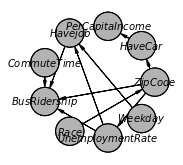

In [452]:
NCmodel.to_daft().render()


In [ ]:
from sklearn.preprocessing import normalize

In [489]:
cpd_Race = TabularCPD('Race', variable_card=3,values=[[.83],[ .13], [.04]])
cpd_ZipCode = TabularCPD ('ZipCode', variable_card=3, values=[
[.8, .15,.05], 
[.15, .05,.8], 
[.05, .8,.15]],
evidence=['Race'], evidence_card=[3])
cpd_CommuteTime = TabularCPD('CommuteTime', variable_card=4, values=[[.04], [.07],[.39], [.50]])
cpd_Havejob = TabularCPD('Havejob', variable_card=2, values=
[[.29], 
[.71]], evidence=['UnemploymentRate'],evidence_card=[1])
#cpd_Weekday = TabularCPD('Weekday', variable_card=7, values=[[.143], [.143],[.143], [.143], [.143], [.143], [.142]])

cpd_HaveCar = TabularCPD('HaveCar', variable_card=2, values=[
[.61, .39,.5],
 [.39, .61,.5]],
 evidence=['ZipCode'], evidence_card=[3])
cpd_PerCapitaIncome = TabularCPD ('PerCapitaIncome', variable_card=2, values=
[[.72, .28,0], 
[.28,.72,1]],
evidence=['HaveCar'],evidence_card=[3])
cpd_UnemploymentRate = TabularCPD ('UnemploymentRate', variable_card=2, values=[
[.89,.11], 
[.11,.89]],evidence=["ZipCode"], evidence_card=[2])

cpd_BusRidership = TabularCPD('BusRidership', variable_card=2,values=[[1],[0]], evidence=["UnemploymentRate","CommuteTime","Havejob","ZipCode"],evidence_card=[1,1,1,1])




NCmodel.add_cpds(cpd_CommuteTime, cpd_HaveCar, cpd_PerCapitaIncome, cpd_UnemploymentRate, cpd_ZipCode, cpd_BusRidership, cpd_Havejob, cpd_Race)


In [484]:
print(cpd_ZipCode)

+------------+---------+---------+---------+
| Race       | Race(0) | Race(1) | Race(2) |
+------------+---------+---------+---------+
| ZipCode(0) | 0.8     | 0.15    | 0.05    |
+------------+---------+---------+---------+
| ZipCode(1) | 0.15    | 0.05    | 0.8     |
+------------+---------+---------+---------+
| ZipCode(2) | 0.05    | 0.8     | 0.15    |
+------------+---------+---------+---------+


In [492]:
NCmodel.get_children("HaveCar")

['PerCapitaIncome']

In [493]:
inference = CausalInference(NCmodel)
inference.query(variables=["BusRidership"], adjustment_set= ["HaveCar"])

ValueError: The cardinality of HaveCar doesn't match in it's child nodes.

In [385]:
NCmodel.get_children("HaveCar")

['PerCapitaIncome', 'Havejob']

In [322]:
cpd_Race.cardinality


array([3])

In [323]:
cpd_ZipCode.cardinality

array([3, 1])

In [437]:
NCmodel.get_cardinality()

defaultdict(int, {})

In [260]:
NCmodel.nodes()

NodeView(('ZipCode', 'HaveCar', 'PerCapitaIncome', 'Havejob', 'CommuteTime', 'BusRidership', 'Race', 'UnemploymentRate', 'Weekday'))

In [283]:
VariableElimination(NCmodel)


ValueError: The cardinality of Race doesn't match in it's child nodes.

In [263]:
NCmodel.get_independencies("BusRidership")

['PerCapitaIncome \\perp CommuteTime, Weekday',
 'PerCapitaIncome \\perp CommuteTime, Weekday \\mid UnemploymentRate',
 'PerCapitaIncome \\perp CommuteTime \\mid Weekday',
 'PerCapitaIncome \\perp UnemploymentRate, CommuteTime, Weekday, Race \\mid ZipCode',
 'PerCapitaIncome \\perp CommuteTime, Weekday \\mid Race',
 'PerCapitaIncome \\perp CommuteTime \\mid Havejob',
 'PerCapitaIncome \\perp UnemploymentRate, Weekday, ZipCode, Race, CommuteTime \\mid HaveCar',
 'PerCapitaIncome \\perp Weekday \\mid CommuteTime',
 'PerCapitaIncome \\perp CommuteTime \\mid UnemploymentRate, Weekday',
 'PerCapitaIncome \\perp CommuteTime, Weekday, Race \\mid UnemploymentRate, ZipCode',
 'PerCapitaIncome \\perp CommuteTime, Weekday \\mid UnemploymentRate, Race',
 'PerCapitaIncome \\perp CommuteTime \\mid UnemploymentRate, Havejob',
 'PerCapitaIncome \\perp CommuteTime, Weekday, ZipCode, Race \\mid UnemploymentRate, HaveCar',
 'PerCapitaIncome \\perp Weekday \\mid UnemploymentRate, CommuteTime',
 'PerCapita